In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as snb
import json

In [2]:
train_dat = pd.read_json("data/train.json")

In [4]:
total_cusines = train_dat.groupby('cuisine')['id'].count()

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from nltk.stem import *
from nltk import wordpunct_tokenize, word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.svm import *
import string
import itertools

In [6]:
stemmer = SnowballStemmer("english")
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t.encode('ascii','ignore').lower()) for t in word_tokenize(doc)
                if t not in string.punctuation]
    def transform(self,doc):
        return self.__call__(doc)
# Smooth idf, sublinear df, norm
lemma_normalizer = LemmaTokenizer()

In [39]:
# normalize_ingres = lambda ingres: str([lemma_normalizer.transform(ingre) for ingre in ingres])
def normalize_ingres(ingres):
    result = [lemma_normalizer.transform(ingre) for ingre in ingres]
    return list(itertools.chain(*result))

In [35]:
train_dat['ingre_str'] = train_dat.ingredients.map(normalize_ingres)

In [36]:
ingredientsPerCuisine = train_dat.drop(['id','ingredients'], axis=1).groupby('cuisine')

In [37]:
cuisine =ingredientsPerCuisine.agg(np.sum)

In [28]:
import matplotlib.pyplot as plt

In [31]:
# fig, axes = plt.subplots(nrows=10, ncols=2, sharex=False, sharey=False, figsize=(30,60))
# for i, c in enumerate(list(ingredientsPerCuisine.index)):
#     ingredientsPerCuisine.iloc[i].sort(inplace=False,ascending=False)[:10].plot(kind='barh', ax=axes[int(i/2), int(i%2)], title=c)
#     axes[int(i/2), int(i%2)].invert_yaxis()

# fig.tight_layout()

In [44]:
bags_of_words = [ Counter(recipe) for recipe in train_dat.ingredients ]

In [46]:
sumbags = sum(bags_of_words, Counter())

In [49]:
train_dat['recipes'] = bags_of_words

In [50]:
ingredientsPerCuisine = train_dat.drop(['id','ingredients','ingre_str'], axis=1).groupby('cuisine')

In [51]:
cuisine =ingredientsPerCuisine.agg(np.sum)

In [58]:
cuisine.iloc[0].sort_values().recipes

Counter({u'1% low-fat milk': 1,
         u'2% reduced-fat milk': 1,
         u'Hawaiian salt': 1,
         u'Italian parsley leaves': 2,
         u'Italian seasoned breadcrumbs': 1,
         u'Jell-O Gelatin Dessert': 1,
         u'Sriracha': 1,
         u'Sugar in the Raw': 1,
         u'Tabasco Pepper Sauce': 4,
         u'acai juice': 1,
         u'active dry yeast': 3,
         u'adobo style seasoning': 1,
         u'agave nectar': 4,
         u'alcohol': 1,
         u'all purpose unbleached flour': 2,
         u'all-purpose flour': 18,
         u'allspice berries': 1,
         u'almond butter': 3,
         u'almond milk': 9,
         u'amber': 1,
         u'ancho powder': 1,
         u'andouille sausage': 1,
         u'anise seed': 1,
         u'annatto': 1,
         u'apple cider vinegar': 1,
         u'apple juice': 1,
         u'apple pie spice': 1,
         u'apples': 5,
         u'apricots': 1,
         u'arrow root': 1,
         u'avocado': 10,
         u'a\xe7ai': 14,
     

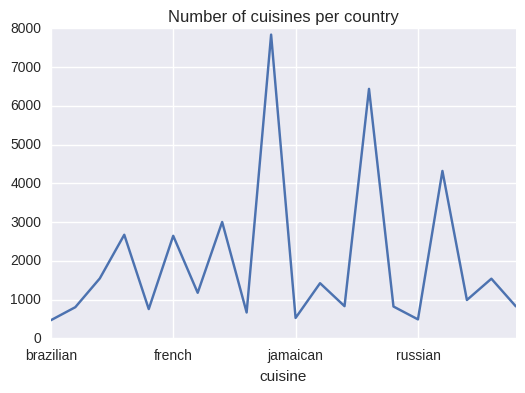

In [18]:
ax = plt.subplot()
ax.set_xlabel("Country")
total_cusines.plot(title="Number of cuisines per country", ax=ax)

# We visualize the cluster of different cuisines

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [5]:
def join(lst):
    return " ".join(lst) 

In [6]:
ingredients = train_dat.ingredients.apply(join)

In [7]:
tfIdfVectorizer = TfidfVectorizer(sublinear_tf=True)

In [8]:
vectorIngredient = tfIdfVectorizer.fit_transform(ingredients).toarray()

In [9]:
pcaComponent = PCA(n_components=2)

In [10]:
reduceIngredients = pcaComponent.fit_transform(vectorIngredient)

In [12]:
# np.savez("PCA_2",vector=reduceIngredients)

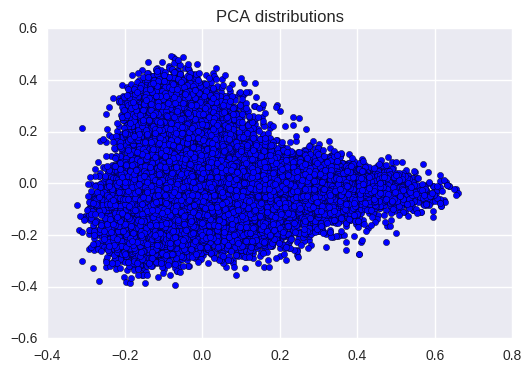

In [18]:
ax = plt.subplot()
ax.set_title("PCA distributions")
ax.scatter(x=reduceIngredients[:,0],y=reduceIngredients[:,1])

In [39]:
cluster = KMeans(3, n_init=10, init='k-means++',n_jobs=-1)

In [40]:
cluster.fit(reduceIngredients)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [44]:
cluster_points = cluster.predict(reduceIngredients)
cuisines = train_dat.cuisine

# Calculate Jaccard Similiarity

In [51]:
def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    
    for i in range(len(json)):
        
        # just changing the name of one of the cuisines so
        # it is more readable in the final visualization
        cuisine = json[i]['cuisine']
        if cuisine == 'southern_us':
            cuisine = 'southUS'

        ingredientsPerCuisine = json[i]['ingredients']
        
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)
            dictCuisineIngred[cuisine] = ingredientsPerCuisine
            
        else: 
            currentList = dictCuisineIngred[cuisine]
            currentList.extend(ingredientsPerCuisine)
            dictCuisineIngred[cuisine] = currentList
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) # unique list of ALL ingredients
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients
dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)

In [52]:
i = 0 
j = 0 
labels = cluster_points
effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: # if it is A itself - we obviously wouldn't want this (will be exactly 1)
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
    i += 1

In [ ]:

from pylab import *
from scipy import *
import matplotlib.pyplot as plt

rdata = reduceIngredients
i=0
figureRatios = (15,20)
x = []
y = []
color = []
area = []

#creating a color palette:
colorPalette = ['#009600','#2980b9', '#ff6300','#2c3e50', '#660033'] 
# green,blue, orange, grey, purple

plt.figure(1, figsize=figureRatios)

for data in rdata:
    
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    try:
        area.append(effect_on_cluster[i]*27000) # magnifying the bubble's sizes (all by the same unit)
        text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
        i += 1
    except: 
        print i
    # plotting the name of the cuisine:
   
    
plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off') # removing the PC axes

plt.show()


20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2